## 数据读入以及数据特征描述

In [64]:
import numpy as np
import lightgbm as lgb
from gmpy2 import random_state
from lightgbm import early_stopping
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from tensorflow import estimator



df = pd.read_csv("pubg_data/train_V2.csv")

print(df.head())
print(df.tail())
print(df.describe())#常用信息
print(df.info())#各列信息
print(np.unique(df['matchId']).shape)#比赛数(排除了重复项
print(np.unique(df['groupId']).shape)#队伍数(排除了重复项

               Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1   

#### 查找空数据,数量较少直接删除

In [65]:
df.isnull()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4446962,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4446963,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4446964,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
np.any(df.isnull())

True

In [67]:
df[df['winPlacePerc'].isnull()]
train=df

In [68]:
train.drop(2744604, inplace=True)
train.shape

(4446965, 29)

In [69]:
# 显示每场比赛参加人数
# transform的作用类似实现了一个一对多的映射功能，把统计数量映射到对应的每个样本上
count = train.groupby('matchId')['matchId'].transform('count')

train['playersJoined'] = count
#从而得出每场比赛有多少人参与
count.count()

train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


In [70]:
np.any(train.isnull())

False

### 排除异常数据
通过列表等方式找出异常数据并删除

In [71]:
train['playersJoined'].sort_values().head() #按升序排序,发现有的比赛只有个位数的人参加

1206365    2
2109739    2
3956552    5
3620228    5
696000     5
Name: playersJoined, dtype: int64

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


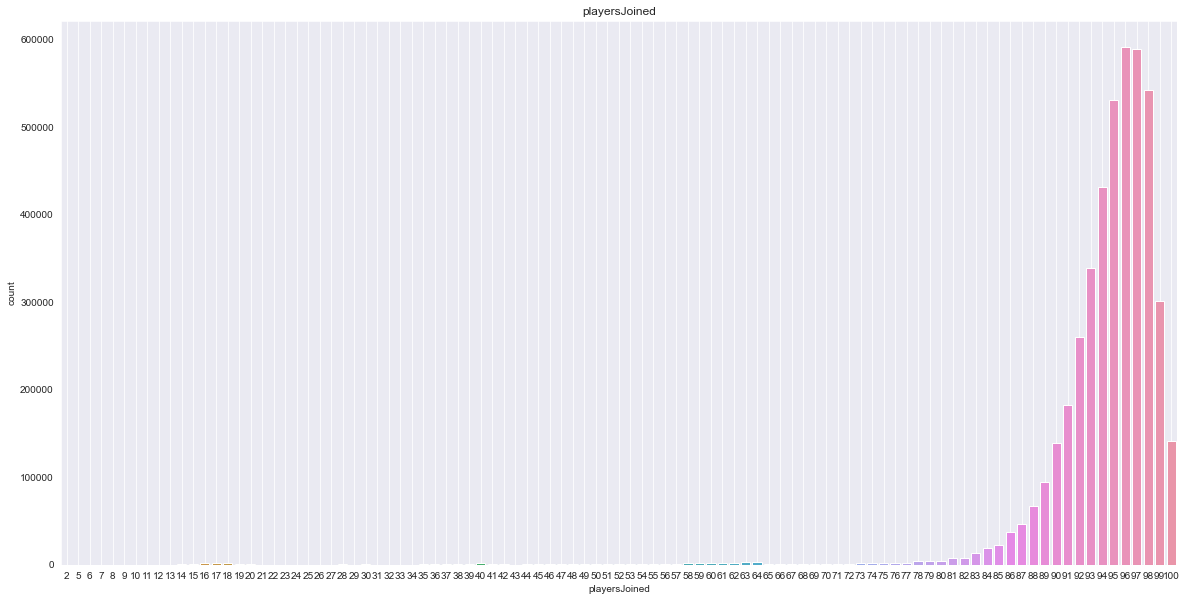

In [72]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.countplot(train['playersJoined'])
plt.title('playersJoined')
plt.grid()
plt.show()

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


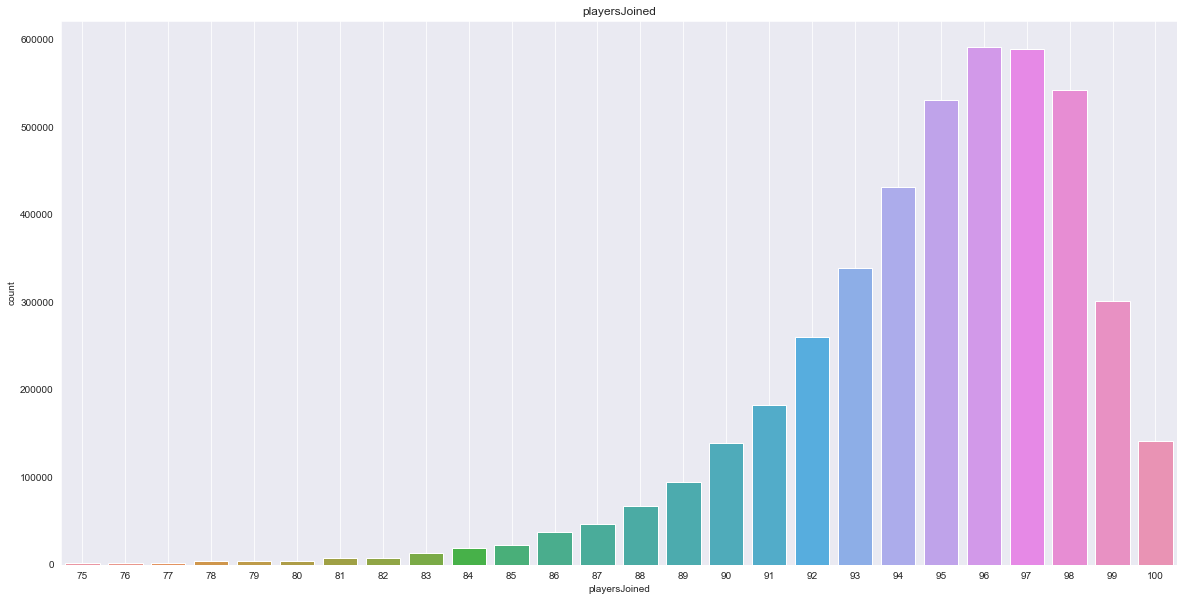

In [73]:
# 限制每局开始人数大于等于75，再进行绘制。
# 再次绘制每局参加人数的直方图
plt.figure(figsize=(20,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.grid()
plt.show()
#75人以上参加比赛的数量比较可观

In [74]:
# 变量合成创建新变量“healsandboosts”
train['healsandboosts'] = train['heals'] + train['boosts']
train[["heals", "boosts", "healsandboosts"]].tail()
#此处我们把特征：heals(使用治疗药品数量)和boosts(能量、道具使用数量)合并成一个新的变量，命名：”healsandboosts“

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [75]:
'''
4.2.4.1 异常值处理：删除有击杀，但是完全没有移动的玩家
异常数据处理：

一些行中的数据统计出来的结果非常反常规，那么这些玩家肯定有问题，为了训练模型的准确性，我们会把这些异常数据剔除

通过以下操作，识别出玩家在游戏中有击杀数，但是全局没有移动；

这类型玩家肯定是存在异常情况（挂**），我们把这些玩家删除。'''
# 创建新变量，统计玩家移动距离
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
# 创建新变量，统计玩家是否在游戏中，有击杀，但是没有移动，如果是返回True, 否则返回false
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))


In [76]:
np.any(train['killsWithoutMoving'].isnull())

False

In [77]:
train[train['killsWithoutMoving']==True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0,0,0.0,8,0,0.8571,58,3,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0,0,0.0,22,0,0.6000,42,6,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0,0,0.0,13,0,0.8947,21,5,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0,0,0.0,7,1500,0.0000,73,0,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0,0,0.0,10,0,0.3000,42,0,0.0,True


找出train['killsWithoutMoving']为True的块,异常数据自然要删除

In [78]:
train[train['killsWithoutMoving']==True].index

Int64Index([   1824,    6673,   11892,   14631,   15591,   20881,   23298,
              24640,   25659,   30079,
            ...
            4426500, 4429697, 4432954, 4436511, 4437516, 4440232, 4440898,
            4440927, 4441511, 4446682],
           dtype='int64', length=1535)

In [79]:
train.shape
train.drop(train[train['killsWithoutMoving']==True].index,inplace=True)
train.drop(train[train['roadKills']==True].index,inplace=True)

In [80]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,244.80,1,1466,0.4444,96,0,244.8000,False
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,1434.00,5,0,0.6400,91,0,1445.0445,False
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,161.80,2,0,0.7755,98,0,161.8000,False
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,202.70,3,0,0.1667,91,0,202.7000,False
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,49.75,2,0,0.1875,97,0,49.7500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0,1019.00,3,1507,0.1786,94,0,2311.0000,False
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0,81.70,6,0,0.2935,93,1,81.7000,False
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0,788.70,4,0,0.4815,98,0,790.8840,False
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0,2748.00,8,0,0.8000,94,6,2748.0000,False


行数减少,上述的异常数据(驾车杀敌过多和无移动杀敌)的行已被删除

In [81]:
train[train['kills']>30].shape#杀敌数过多

(95, 33)

In [82]:
train.drop(train[train['kills']>30].index,inplace=True)

In [83]:
train.shape

(4434088, 33)

In [84]:
#如果一个玩家的击杀爆头率过高，也说明其有问题
# 创建变量爆头率
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0) #可能有除以0的情况出现,这些值均为NaN

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


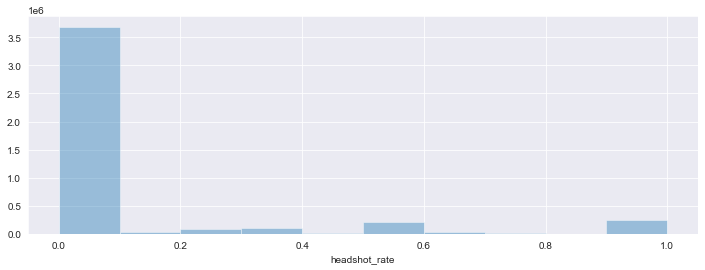

In [85]:
# 绘制爆头率图像
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10, kde=False)
plt.show()

显然,右侧存在一些异常的爆头率数据,将其剔除

In [86]:
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape


(24, 34)

In [87]:
train.drop(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].index, inplace=True)

In [88]:
train.shape

(4434064, 34)

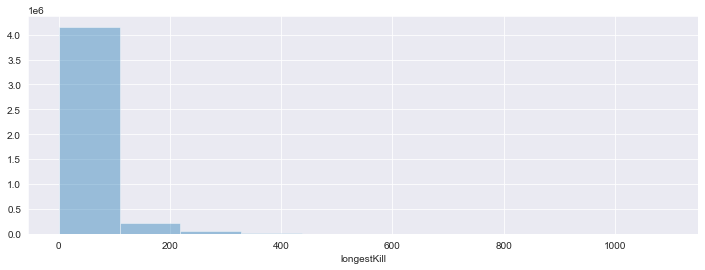

(4434044, 34)

In [89]:
# 绘制图像
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10, kde=False)
plt.show()
# 找出最远杀敌距离大于等于1km的玩家
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)
train.shape


In [90]:
#异常值处理：删除关于运动距离的异常值
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)


In [91]:
# 异常值处理：删除使用治疗药品数量异常值
train.drop(train[train['heals'] >= 40].index, inplace=True)


## 数据编码化处理
#### 对于类别较少的数据,可以使用one-hot方式进行处理,如train['matchType']
#### 对于类别非常多的数据,直接转换成数值,如 train["groupId"]和 train['matchId']

In [92]:
# 关于比赛类型，共有16种方式
train['matchType'].unique()
'''
array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)
       '''

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [93]:
# 对matchType进行one_hot编码
# 通过在后面添加的方式,实现,赋值并不是替换
train = pd.get_dummies(train, columns=['matchType'])


In [94]:
train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,0,0,0,0,0,0,0,1
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,0,0,0,0,0,0,0,1
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,0,0,0,0,0,0,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,0,0,0,0,0,0,0,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0,0,0,0,0,0,0,0,1
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0,0,0,0,0,1,0,0,0
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0,0,0,0,0,0,0,0,1
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0,0,0,0,0,0,0,0,1


In [95]:
#关于groupId,matchId这类型数据，也是类别型数据。但是它们的数据量特别多，如果你使用one-hot编码，无异于自杀。
#在这儿我们把它们变成用数字统计的类别型数据依旧不影响我们正常使用。
#将字符串型的数据转换为分类数据,下述两行将数据变成从0开始的数字
train['groupId'] = train['groupId'].astype('category')
train["groupId_cat"] = train["groupId"].cat.codes
train["groupId_cat"].head()

0     612486
1     826096
2     841768
3    1337732
4    1754237
Name: groupId_cat, dtype: int32

In [96]:
# 转换match_id(同上
train['matchId'] = train['matchId'].astype('category')

train['matchId_cat'] = train['matchId'].cat.codes

# 删除之前列
train.drop(['groupId', 'matchId'], axis=1, inplace=True)

# 查看新产生列
train[['groupId_cat', 'matchId_cat']].head()


,groupId_cat,matchId_cat
0,612486,30085
1,826096,32751
2,841768,3143
3,1337732,45260
4,1754237,20531


In [97]:
train.head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,...,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat
0,7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,...,0,0,0,0,0,0,0,1,612486,30085
1,eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,...,0,0,0,0,0,0,0,1,826096,32751
2,1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,...,0,0,0,0,0,0,0,0,841768,3143
3,4616d365dd2853,0,0,32.90,0,0,0,75,0,0,...,0,0,0,0,0,0,0,1,1337732,45260
4,315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,...,0,0,0,0,0,1,0,0,1754237,20531


In [98]:
train.shape

(4433542, 49)

In [104]:
# 确定特征值和目标值
x = train.drop(["winPlacePerc", "Id"], axis=1) #特征值

y = train['winPlacePerc'] # target
y.head()

0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
Name: winPlacePerc, dtype: float64

In [105]:
x.shape

(4433542, 47)

模型训练
  1.RF模型

In [106]:
#数据分割
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2)


In [108]:
# 模型训练
from sklearn.ensemble import RandomForestRegressor
m1 = RandomForestRegressor(n_estimators=40, 
                           min_samples_leaf=3, 
                           max_features='sqrt',
                           n_jobs=-1)

m1.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [110]:
y_pre = m1.predict(X_valid)
print(m1.score(X_valid, y_valid))#模型准确率约为0.923
print(mean_absolute_error(y_true=y_valid, y_pred=y_pre))#mae=0.060

0.9230867436715275
0.06049533416907304


In [111]:
# 查看特征值在当前模型中的重要程度
m1.feature_importances_

array([3.56240798e-03, 1.13294405e-01, 1.96199961e-02, 3.50574520e-03,
       8.71970449e-04, 3.31430762e-02, 1.50120134e-01, 2.19282757e-03,
       1.74717825e-02, 8.06190847e-03, 2.79442152e-02, 1.66232715e-02,
       7.51092990e-03, 9.09685287e-03, 3.83927647e-03, 1.06956694e-03,
       3.02789287e-02, 1.79409899e-05, 4.91399156e-03, 1.88577400e-04,
       1.76306290e-04, 2.01043016e-01, 1.08468165e-01, 2.60100088e-03,
       7.90902412e-03, 4.29651673e-02, 1.64833223e-01, 0.00000000e+00,
       3.66553791e-03, 5.97980691e-05, 1.54886169e-06, 2.86337568e-04,
       7.13683315e-04, 1.26669793e-06, 6.74172417e-06, 5.46369295e-07,
       1.52811820e-04, 7.98841777e-07, 2.06404362e-05, 1.81242852e-06,
       3.71666434e-04, 3.62306696e-04, 1.53276701e-03, 1.46048286e-03,
       1.14475954e-03, 4.44382675e-03, 4.44895894e-03])

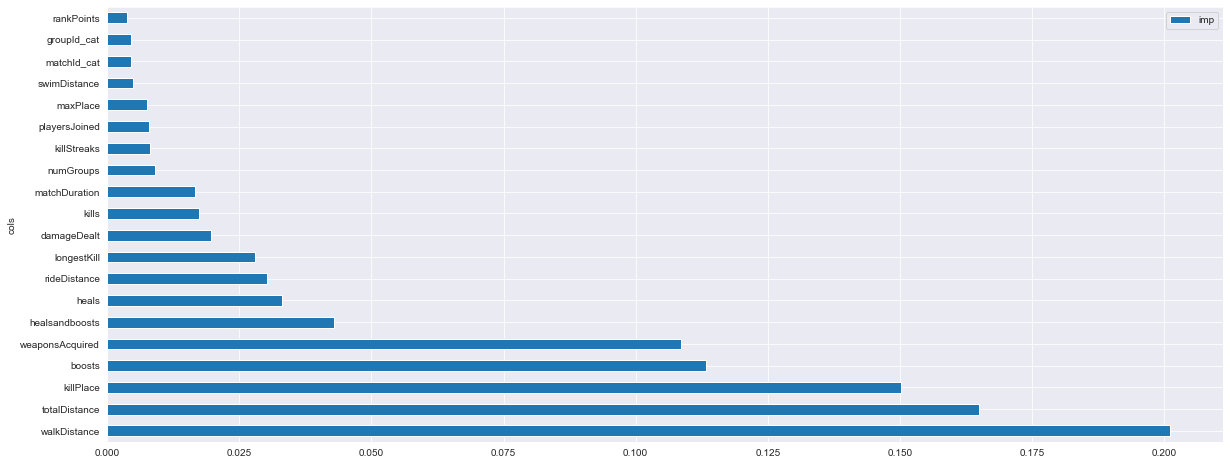

In [112]:
imp_df = pd.DataFrame({"cols":df.columns, "imp":m1.feature_importances_})
imp_df = imp_df.sort_values("imp", ascending=False) #排序
# 绘制特征重要性程度图，仅展示排名前二十的特征
imp_df[:20].plot('cols', 'imp', figsize=(20,8), kind = 'barh')
plt.show()

In [113]:
# 保留比较重要的特征
to_keep = imp_df[imp_df.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  16


21       walkDistance
26      totalDistance
6           killPlace
1              boosts
22    weaponsAcquired
25     healsandboosts
5               heals
16       rideDistance
10        longestKill
2         damageDealt
8               kills
11      matchDuration
13          numGroups
9         killStreaks
24      playersJoined
12           maxPlace
Name: cols, dtype: object

In [115]:
# 由这些比较重要的特征值，生成新的df
df[to_keep].shape #仅保留了16个特征


(4433542, 16)

In [118]:
# 新模型训练
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)

m2.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

# 模型评分
y_pre = m2.predict(X_valid)

In [122]:
print(m2.score(X_valid, y_valid))
print(mean_absolute_error(y_true=y_valid, y_pred=y_pre))
'''
原49个特征的准确率=0.9230867436715275
原49个特征的mae=0.06049533416907304
新结果比原结果更好,显然防止了过拟合
'''

0.9233182739912109
0.060224476450149084


In [124]:
print(imp_df)#各元素对模型预测结果的影响程度

                          cols           imp
21                walkDistance  2.010430e-01
26               totalDistance  1.648332e-01
6                    killPlace  1.501201e-01
1                       boosts  1.132944e-01
22             weaponsAcquired  1.084682e-01
25              healsandboosts  4.296517e-02
5                        heals  3.314308e-02
16                rideDistance  3.027893e-02
10                 longestKill  2.794422e-02
2                  damageDealt  1.962000e-02
8                        kills  1.747178e-02
11               matchDuration  1.662327e-02
13                   numGroups  9.096853e-03
9                  killStreaks  8.061908e-03
24               playersJoined  7.909024e-03
12                    maxPlace  7.510930e-03
18                swimDistance  4.913992e-03
46                 matchId_cat  4.448959e-03
45                 groupId_cat  4.443827e-03
14                  rankPoints  3.839276e-03
28               headshot_rate  3.665538e-03
0         